In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import torch
import torch.nn as nn
import random
from PIL import Image
import PIL.ImageOps    
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision
import numpy as np
from torch.autograd import Variable
from scipy import spatial
import sys
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*256*256, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

net=torch.load("shangyan_300")
def find_vector(image1):
    transform=transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()])
    image1 = image1.convert("L")
    image1 = transform(image1)
    image1.unsqueeze_(1)
    output1,output2 = net(Variable(image1).cuda(),Variable(image1).cuda())
    return (output1.cpu().detach().numpy()[0])




In [3]:
import pymongo
myclient = pymongo.MongoClient('mongodb://localhost:27017/')
mydb = myclient["mia_data"]
mycol = mydb["sim_feature"]
cursor = mycol.find(
     {},
     no_cursor_timeout=True
)
aa = []
bb = []
for x in cursor:
    if(len(x["vec"])!=128):
        continue
    aa.append(x["path"])
    bb.append(x["vec"])

data = (np.array(bb)*100).astype(int)

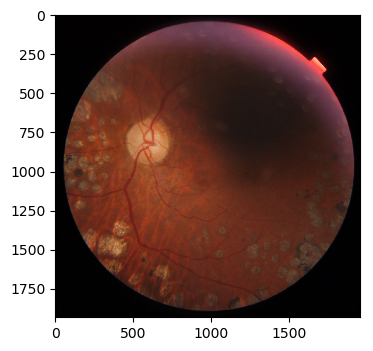

[ -21  -28    5   40   34   30   25    4  -58    5  -28   61  -69   16
  -13   72  -47  -30   10  -38  -13   -9  -12   80   41   59  -72  -47
    3  -52   11   80   46  -28   -9   33    4  -90  -49   31   13   28
   -5  -29   60    2   53   19   49  -28    3   39   19   20   10   -5
   23  -42  -33    0   23   18   80  -36   80  -55   44   60   93   26
   10   84  -27   47   11    0  -10  -30  -21    6    6   12   44   11
    7   48  -26   16   -3  -14   -1   52  -75    2   28  -13    4 -100
    7   35   32  -13   16   23   59   21   -7   39   91    0  -15  -63
    0   -4  -48  -33    1   -2    2   30  -20    1   24   24  -13  -15
  -85  -34]


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [7, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
path = "/home/data/12-13141516-images/topcon/12-1516/0329/TOPCON_0329_20181216_102507_Color_L_073.JPG"
k = 5
try:
    image = Image.open(path)   
    plt.imshow(image)
    plt.show()
    vect = find_vector(image).tolist() 
    target = (np.array(vect)*100).astype(int)
    print(target)
except IOError:
    print("image not exist")


In [6]:
from ctypes import *
import ctypes
program = CDLL('./most_similar.so')
INPUT = c_double * 20
datas = INPUT()
program.most_similar.restype = POINTER(c_int)
res_int = program.most_similar(20,data.shape[0],ctypes.c_void_p(data.ctypes.data),ctypes.c_void_p(target.ctypes.data),datas)
output = []
for x in range(10):
    output.append(aa[res_int[x]])
    #image = Image.open(aa[res_int[x]])
    #plt.imshow(image)
    #plt.show()
print(output)

['/ssd2/data/hz_data/desensitization/e308c3057626877f90cedbe7d9b544c3_L.png', '/ssd2/data/hz_data/desensitization/5128d19624abe79c4511c35076819064_L.png', '/ssd2/data/hz_data/desensitization/7d1eb1d9b4ee4d64c078574a60261b0f_L.png', '/ssd2/data/hz_data/desensitization/ec31cf72a30693d5d68c49a145d0d90e_L.png', '/ssd2/data/hz_data/desensitization/6d569f7d9802dae6e4b02e69650aa142_L.png', '/ssd2/data/hz_data/desensitization/65816215443e2912ca57b2bd4da42a3f_L.png', '/ssd2/data/hz_data/desensitization/dc391a7fd5db75f16940d12bf2b0f523_L.png', '/ssd2/data/hz_data/desensitization/132b139e84ba5a1559bc358f41e6db91_L.png', '/ssd2/data/fushi/fushi_original_data_20200217/20191106/5dc226425b789c07f62dfd06.jpg', '/ssd2/data/hz_data/desensitization/8168910adb7898bac1bc9bec11b26258_L.png']


In [20]:
print(bb[0])

[0.09553957730531693, -0.41901254653930664, 0.35261431336402893, 0.4453354477882385, 0.30208128690719604, 0.7375279664993286, 0.26563793420791626, -0.15039458870887756, -0.2778586745262146, -0.09645486623048782, -0.4950980842113495, 0.10838055610656738, -0.6380831003189087, 0.351765513420105, 0.038030222058296204, 0.6256042718887329, -0.2106778919696808, -0.01524745300412178, 0.2971886396408081, 0.1520039439201355, 0.29871830344200134, -0.012072280049324036, -0.006840437650680542, 0.3245527446269989, 0.2633802890777588, 0.23436298966407776, -0.23000778257846832, 0.043581653386354446, 0.22629205882549286, -0.12726013362407684, -0.43428221344947815, 0.35954973101615906, 0.5492197871208191, -0.032600369304418564, -0.09551756083965302, 0.28994250297546387, 0.02276962623000145, -0.7213797569274902, -0.0855189859867096, 0.2202879786491394, 0.03248429298400879, 0.018515806645154953, -0.16628581285476685, -0.08053809404373169, 0.3485151529312134, 0.060043592005968094, 0.39166101813316345, 0.21